In [1]:
use_cuda = True

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from EEG import EEG
from init_TF import init_TF
from behavior import load_posBin

In [5]:
torch.cuda.is_available()

True

In [6]:
eeg = EEG()
eeg.load('../EEG/1_EEGfilt.mat')
eeg.drop_artifacts()
eeg.drop_electrodes()

posBin = load_posBin(f'..\\data\\1_Behavior.mat')
posBin = posBin[eeg.art.artInd.transpose()==0]

assert(eeg.eeg.shape == (float(eeg.nTrials - sum(eeg.art.artInd)), nElectrodes, (float(eeg.postTime-eeg.preTime)/4)+1))

NameError: name 'nElectrodes' is not defined

[Text(0.5, 1.0, 'Position of bin = [6]')]

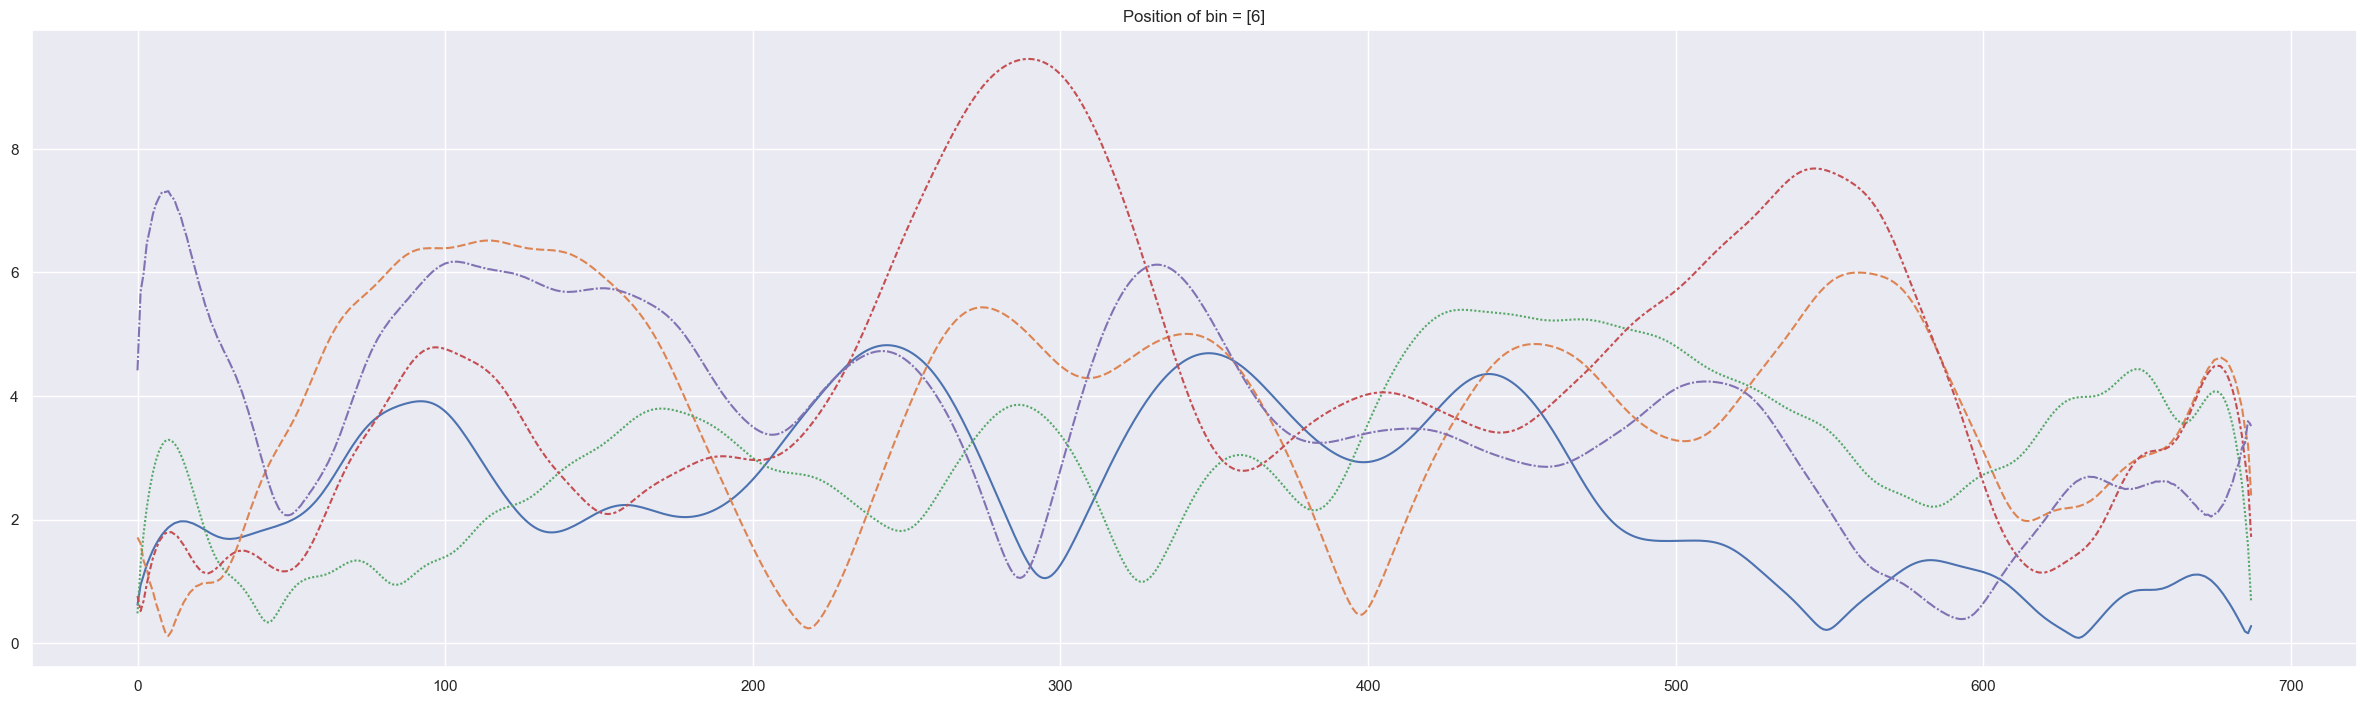

In [7]:
trial_number = 3
sns.set(rc={'figure.figsize':(30,8.27)})
sns.lineplot(data=eeg.eeg_total()[(posBin==5).transpose()[0], 10, :].transpose()[:, :5], legend=False).set(title=f'Position of bin = {posBin[trial_number-1]}')

In [8]:
eeg.eeg_total().shape

(1223, 20, 688)

In [9]:
class EEGDataset(Dataset):
    def __init__(self, eeg, posBin, start=0, end=1):
        length = eeg.eeg_total().shape[0]
        self.data = eeg.eeg_total()[int(start*length):int(end*length)]
        self.posBin = posBin
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx].transpose(), self.posBin[idx][0]

In [10]:
def data_loader(data=eeg, batch_size= 32):
    train_set = EEGDataset(eeg, posBin, 0, 0.7)
    val_set = EEGDataset(eeg, posBin, 0.7, 0.85)
    test_set = EEGDataset(eeg, posBin, 0.85, 1)
    if (batch_size == "max"):
        return (DataLoader(train_set, batch_size = len(train_set), shuffle = True), 
                DataLoader(val_set, batch_size = len(val_set), shuffle = True), 
                DataLoader(test_set, batch_size = len(test_set), shuffle = True))
    return (DataLoader(train_set, batch_size = batch_size, shuffle = True), 
            DataLoader(val_set, batch_size = batch_size, shuffle = True), 
            DataLoader(test_set, batch_size = batch_size, shuffle = True))

In [11]:
train_loader, _, _ = data_loader(eeg)
for data, label in train_loader:
    print(data.shape, label)
    break

torch.Size([32, 688, 20]) tensor([6, 1, 1, 4, 6, 3, 2, 4, 7, 3, 1, 6, 2, 5, 5, 3, 5, 2, 0, 1, 1, 0, 1, 7,
        1, 4, 4, 6, 7, 5, 2, 2], dtype=torch.uint8)


In [12]:
#taken from tutorial 5
class RNNModel(nn.Module):
    def __init__(self, input_size=20, hidden_size=100, num_layers=1):
        super(RNNModel, self).__init__()
        self.name = "RNN_Model"
        self.hidden_size = hidden_size
        #self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 50)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(50,25)
        self.fc3 = nn.Linear(25, 8)

    def forward(self, x):
        
        out, _ = self.rnn(x.float(), None)
        out = self.fc1(out[:,-1,:])
        out = nn.ReLU()(self.dropout(out))
        out = self.fc2(out)
        out = nn.ReLU()(self.dropout(out))
        out = self.fc3(out)
        return out

In [13]:
train_loader, _, _ = data_loader(eeg)
model = RNNModel().cuda()
for data, label in train_loader:
    print(model(data.cuda()).shape)
    break

torch.Size([32, 8])


In [14]:
def train_RNN(model, eeg, batch_size, n_epochs):
  BATCH_SIZE = batch_size
  N_EPOCHS = n_epochs

  train_loader, val_loader, test_loader = data_loader(eeg, batch_size = BATCH_SIZE)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=[0.9,0.999], eps=1e-4)

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  epochs = []
  #USING TRAINING LOOP FROM LAB 3
  for epoch in range(N_EPOCHS):

      train_loss = 0.0
      train_corr = 0
      total_train_samples = 0

      for data, labels in iter(train_loader):

            total_train_samples += data.shape[0]

            outputs = model(data.cuda()).squeeze()

            y = labels.detach().cpu().numpy()
            
            loss = criterion(outputs.cuda(), torch.LongTensor(labels.type(torch.LongTensor)).cuda())
            
            y_pred = torch.argmax(outputs.detach().cpu(), dim=1).numpy()
            
            train_corr += (y_pred==y).sum(axis=0)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
      
      
      train_acc = train_corr/total_train_samples

      val_corr = 0
      val_loss = 0.0
      total_val_samples = 0

      for data, labels in iter(val_loader):
        total_val_samples += data.shape[0]
        outputs = model(data.cuda()).squeeze()
        y = labels.detach().cpu().numpy()
        y_pred = torch.argmax(outputs.detach().cpu(), dim=1).numpy() 
        val_corr += (y_pred==y).sum(axis=0)
        loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())

        val_loss += loss.item()
      
      val_acc = val_corr/ total_val_samples

      #model_path = "./models/"+model.name+"epoch"+str(epoch)+".pt"
      
      #torch.save(model.state_dict(), model_path)
      
      train_accuracies.append(train_acc)
      val_accuracies.append(val_acc)
      val_losses.append(val_loss)
      train_losses.append(train_loss)
      epochs.append(epoch)
      
      

      sys.stdout.write(f"Epoch {epoch+1} | training loss = {train_losses[-1]} | training accuracy = {train_accuracies[-1]} | validation loss = {val_losses[-1]} | validation accuracy = {val_accuracies[-1]}\n")

  test_loss = 0.0
  for data, labels in iter(test_loader):
      outputs = model(data.cuda()).squeeze()
      loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
      test_loss += loss.item()

  print(f"Final test loss = {test_loss}")
  
  plt.title("Training Curve")
  plt.plot(epochs, train_losses, label="Train")
  plt.plot(epochs, val_losses, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_accuracies, label="Train")
  plt.plot(epochs, val_accuracies, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  return {'train_losses': train_losses,
  'val_losses': val_losses,
  'train_accuracies':train_accuracies,
  'val_accuracies': val_accuracies}


Epoch 1 | training loss = 56.39559268951416 | training accuracy = 0.125 | validation loss = 12.552050352096558 | validation accuracy = 0.10382513661202186
Epoch 2 | training loss = 56.33154320716858 | training accuracy = 0.1133177570093458 | validation loss = 12.5082848072052 | validation accuracy = 0.11475409836065574
Epoch 3 | training loss = 56.247753620147705 | training accuracy = 0.12383177570093458 | validation loss = 12.610419273376465 | validation accuracy = 0.11475409836065574
Epoch 4 | training loss = 56.26661252975464 | training accuracy = 0.13551401869158877 | validation loss = 12.491162061691284 | validation accuracy = 0.12021857923497267
Epoch 5 | training loss = 56.21444344520569 | training accuracy = 0.125 | validation loss = 12.510725975036621 | validation accuracy = 0.14207650273224043
Epoch 6 | training loss = 56.14328193664551 | training accuracy = 0.13551401869158877 | validation loss = 12.511800289154053 | validation accuracy = 0.10382513661202186
Epoch 7 | traini

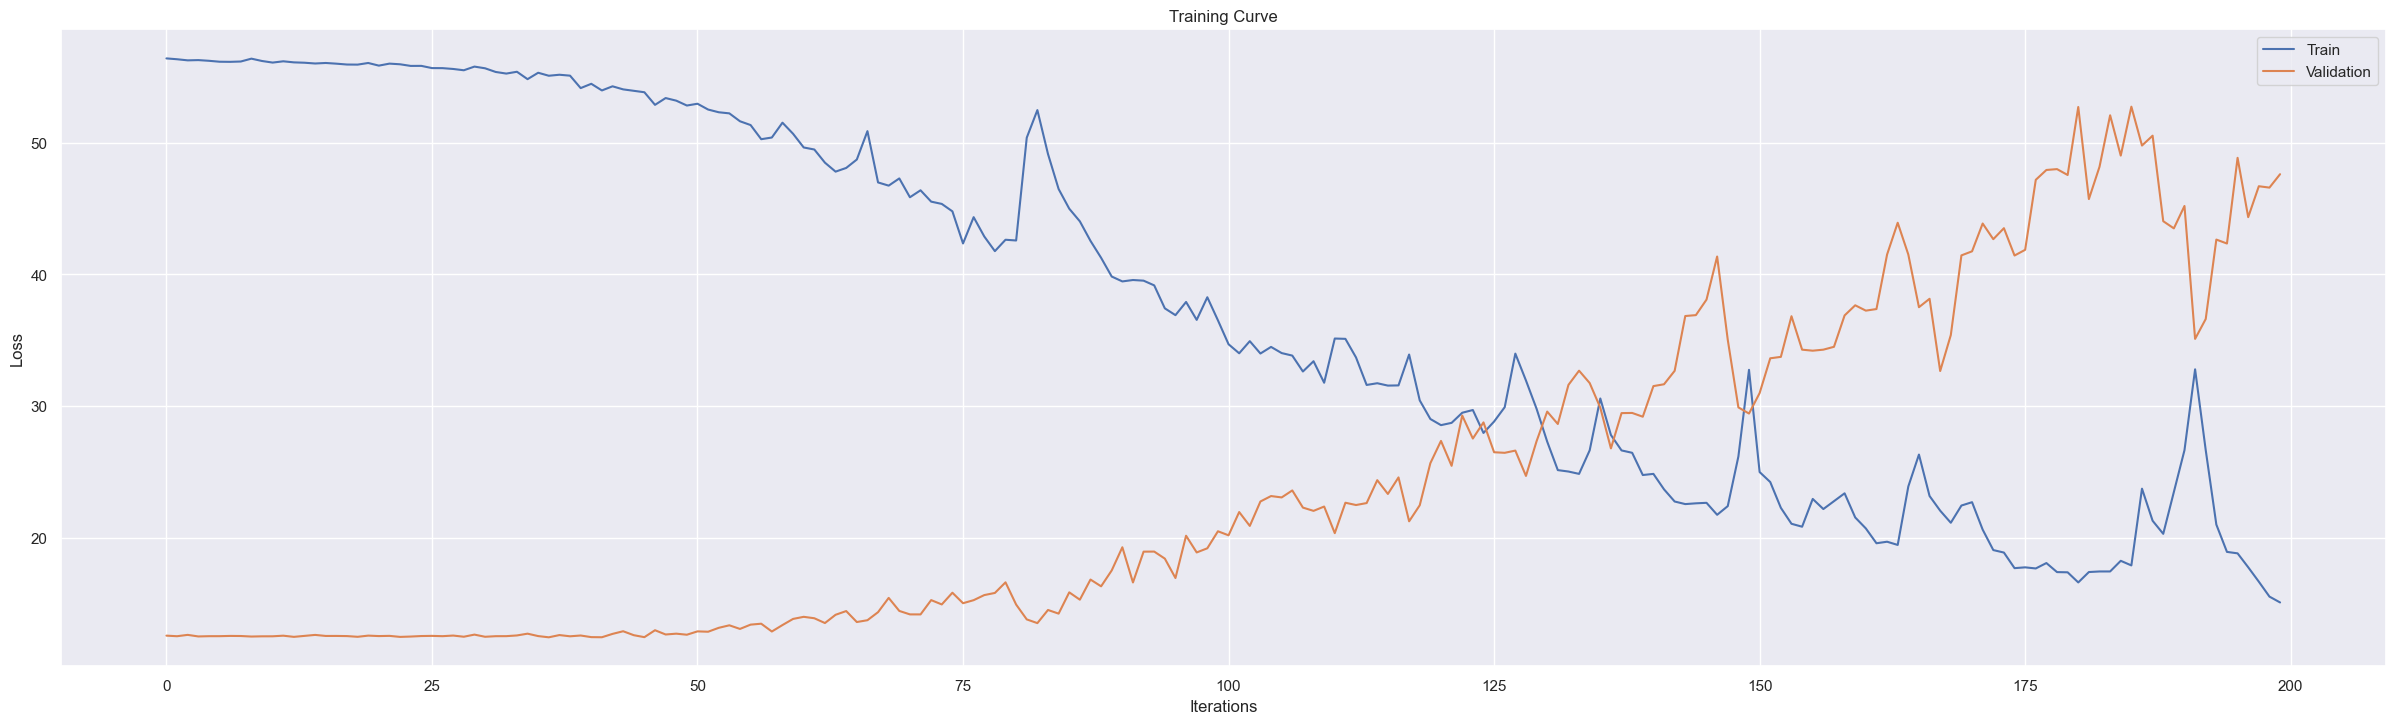

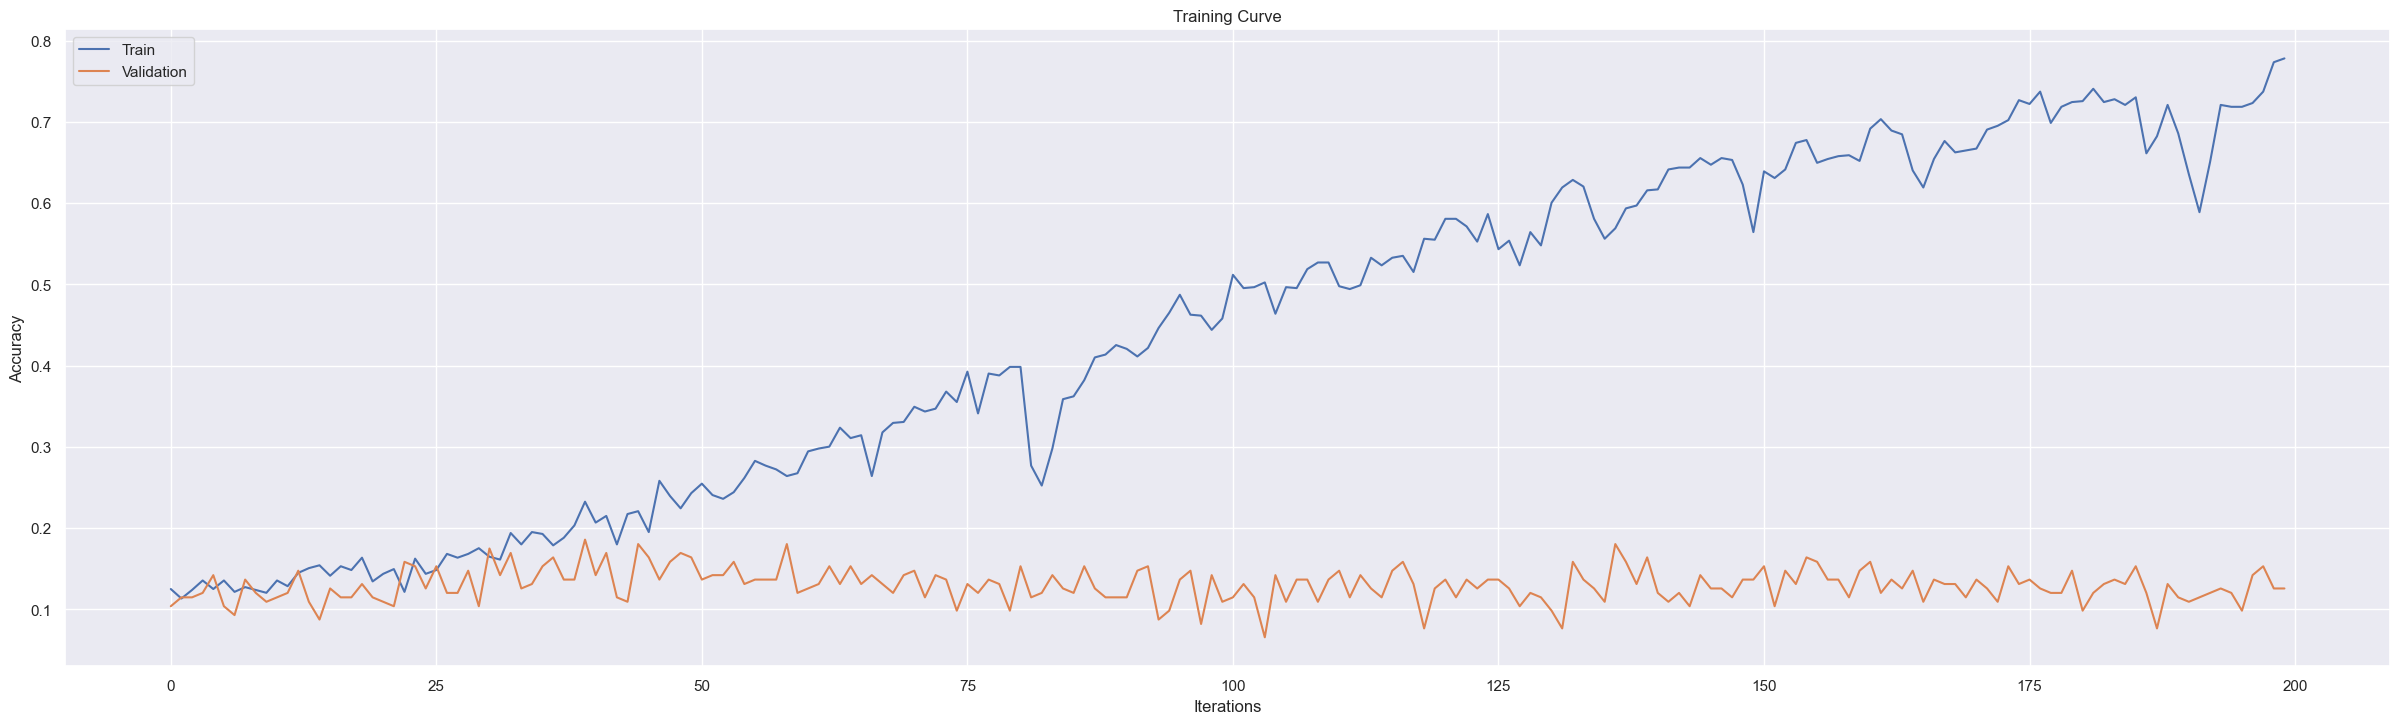

In [15]:
model = RNNModel().cuda()
training_history = train_RNN(model=model, eeg=eeg, batch_size=32, n_epochs=200)